# wevi( https://ronxin.github.io/wevi/ )를 keras로 코딩하기
- 코어닷투데이 김경훈 (2023.09.12.)

# 그림 작성을 위한 한글 폰트 설치
설치하고 런타임 다시 시작을 해주세요

In [51]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator

from keras.models import Sequential
from keras.layers import Dense, Activation

# 데이터셋의 BoW

In [2]:
docs = [
    ['고양이', '강아지', '찾아줘', '우리', '동네', '어딘가', '에', '있어'],
    ['고양이', '찾아줘'],
    ['강아지', '찾아줘'],
    ['우리', '동네', '어딘가', '에', '있어', '맛집', '이']
]

In [3]:
# 모든 문서에서 단어들의 집합을 구한다.
unique_words = set(word for doc in docs for word in doc)

# 각 단어에 unique한 숫자 값을 매겨준다.
word_to_id = {word: idx for idx, word in enumerate(unique_words)}

In [4]:
word_to_id

{'에': 0,
 '고양이': 1,
 '이': 2,
 '있어': 3,
 '맛집': 4,
 '찾아줘': 5,
 '어딘가': 6,
 '동네': 7,
 '우리': 8,
 '강아지': 9}

# One-Hot Encoding

In [5]:
def one_hot_encode(word, word_to_id):
    vector = np.zeros(len(word_to_id), dtype=int) # vector of zeros
    vector[word_to_id[word]] = 1 # set the index of the word to 1
    return vector

In [6]:
one_hot_encode('찾아줘', word_to_id)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [7]:
one_hot_encode('강아지', word_to_id)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [8]:
words = sorted(word_to_id.items(), key=operator.itemgetter(1))
words

[('에', 0),
 ('고양이', 1),
 ('이', 2),
 ('있어', 3),
 ('맛집', 4),
 ('찾아줘', 5),
 ('어딘가', 6),
 ('동네', 7),
 ('우리', 8),
 ('강아지', 9)]

In [9]:
for word, idx in words:
    vec = one_hot_encode(word, word_to_id)
    print(word, '\t', vec)

에 	 [1 0 0 0 0 0 0 0 0 0]
고양이 	 [0 1 0 0 0 0 0 0 0 0]
이 	 [0 0 1 0 0 0 0 0 0 0]
있어 	 [0 0 0 1 0 0 0 0 0 0]
맛집 	 [0 0 0 0 1 0 0 0 0 0]
찾아줘 	 [0 0 0 0 0 1 0 0 0 0]
어딘가 	 [0 0 0 0 0 0 1 0 0 0]
동네 	 [0 0 0 0 0 0 0 1 0 0]
우리 	 [0 0 0 0 0 0 0 0 1 0]
강아지 	 [0 0 0 0 0 0 0 0 0 1]


# 학습 데이터셋 만들기

In [10]:
for doc in docs:
    doc

In [11]:
doc

['우리', '동네', '어딘가', '에', '있어', '맛집', '이']

In [12]:
def create_dataset(doc, window_size=1):
    dataset = []
    for i, word in enumerate(doc):
        start_idx = max(0, i - window_size)
        end_idx = min(len(doc), i + window_size + 1)

        for j in range(start_idx, end_idx):
            if i != j: # 중심 단어는 포함되지 않도록
                dataset.append(word + "|" + doc[j])
    return dataset

In [13]:
dataset = create_dataset(doc, window_size=1)
for d in dataset:
    print(d, end=',')

우리|동네,동네|우리,동네|어딘가,어딘가|동네,어딘가|에,에|어딘가,에|있어,있어|에,있어|맛집,맛집|있어,맛집|이,이|맛집,

In [14]:
dataset

['우리|동네',
 '동네|우리',
 '동네|어딘가',
 '어딘가|동네',
 '어딘가|에',
 '에|어딘가',
 '에|있어',
 '있어|에',
 '있어|맛집',
 '맛집|있어',
 '맛집|이',
 '이|맛집']

In [15]:
train_dataset = []
for s in dataset:
    target_word, near_word = s.split("|")
    v_t = one_hot_encode(target_word, word_to_id)
    v_n = one_hot_encode(near_word, word_to_id)
    train_dataset.append([v_t, v_n])

In [16]:
X = np.array(train_dataset)[:, 0]

In [17]:
X

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
y = np.array(train_dataset)[:, 1]

In [19]:
y

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

# 학습

In [20]:
vec.shape

(10,)

In [21]:
model = Sequential()
model.add(Dense(4, input_dim=10, activation='sigmoid'))
# model.add(Activation('sigmoid'))
model.add(Dense(10, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 44        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
Total params: 94 (376.00 Byte)
Trainable params: 94 (376.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.get_weights()

[array([[ 0.025222  ,  0.5741552 ,  0.12080562,  0.58569634],
        [-0.17288923, -0.53699154, -0.10514653, -0.37629822],
        [-0.00643104,  0.32681537,  0.37029803,  0.49319208],
        [-0.46791232,  0.3510108 , -0.5683162 ,  0.63657725],
        [-0.45151284,  0.59349203,  0.6508167 ,  0.49399698],
        [-0.38183302, -0.2771536 ,  0.18781239,  0.25211954],
        [-0.4580205 ,  0.6142229 ,  0.39805162,  0.39641607],
        [-0.2982262 ,  0.19697106, -0.44225937,  0.01033789],
        [-0.25580698, -0.15870923, -0.6123342 ,  0.45341074],
        [ 0.6234586 , -0.31699985, -0.08031052,  0.6312946 ]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[ 0.08191222, -0.2020253 , -0.6363144 ,  0.07000446, -0.4834938 ,
         -0.46385658, -0.5245047 ,  0.28593647,  0.14429086,  0.47130823],
        [ 0.6046009 ,  0.03957403, -0.30752337,  0.37485206,  0.406986  ,
         -0.02769822,  0.05116451, -0.11048752, -0.49683988,  0.1785934 ],
        [-0.36687

In [24]:
for w in model.get_weights():
    print(w.shape)

(10, 4)
(4,)
(4, 10)
(10,)


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [26]:
history = model.fit(X, y, epochs=1000, verbose=0)

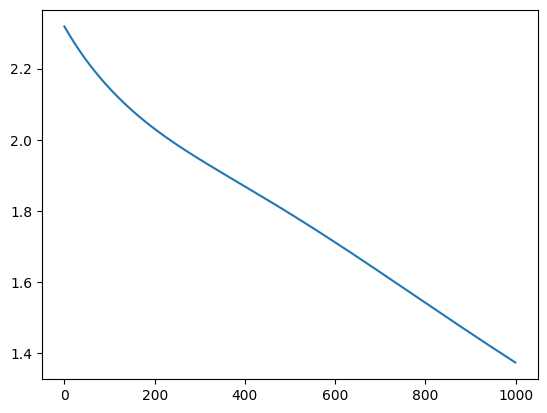

In [27]:
plt.plot(history.history['loss'])

In [28]:
history = model.fit(X, y, epochs=1000, verbose=0)

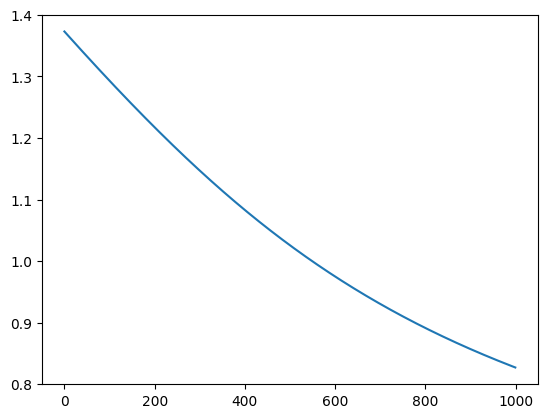

In [29]:
plt.plot(history.history['loss'])

In [30]:
model.get_weights()[0]

array([[ 1.5499657 , -0.6742699 ,  2.2521868 , -0.59803236],
       [-0.17288923, -0.53699154, -0.10514653, -0.37629822],
       [-1.998232  ,  2.5030608 ,  1.8690555 ,  2.8803523 ],
       [-2.5529888 ,  2.1997328 , -1.4694791 ,  2.6128314 ],
       [-2.184122  , -1.7199849 ,  2.8535922 ,  0.98052835],
       [-0.38183302, -0.2771536 ,  0.18781239,  0.25211954],
       [ 0.09692473,  2.799958  , -1.691872  , -1.5586991 ],
       [ 1.737692  , -1.5953758 , -1.5042559 ,  2.0503397 ],
       [ 1.6490554 ,  1.407033  , -2.3048713 , -1.6654625 ],
       [ 0.6234586 , -0.31699985, -0.08031052,  0.6312946 ]],
      dtype=float32)

# 학습된 가중치들의 시각화

In [31]:
from sklearn.decomposition import PCA

In [32]:
vectors_input = model.get_weights()[0]

In [33]:
# PCA로 2D로 변환
pca = PCA(n_components=2)
result = pca.fit_transform(vectors_input)

In [34]:
result

array([[ 0.01263171, -2.7377656 ],
       [ 0.41905677, -0.867684  ],
       [-3.1653554 ,  2.184176  ],
       [-1.2942581 ,  3.5167408 ],
       [-3.422619  , -1.8447075 ],
       [-0.18099713, -0.5538835 ],
       [ 2.626861  ,  1.9693716 ],
       [ 0.91940975, -1.3321272 ],
       [ 3.7469566 ,  0.47350723],
       [ 0.338315  , -0.8076279 ]], dtype=float32)

In [35]:
sorted(word_to_id.items(), key=operator.itemgetter(1))

[('에', 0),
 ('고양이', 1),
 ('이', 2),
 ('있어', 3),
 ('맛집', 4),
 ('찾아줘', 5),
 ('어딘가', 6),
 ('동네', 7),
 ('우리', 8),
 ('강아지', 9)]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51080 (\N{HANGUL SYLLABLE ISS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyt

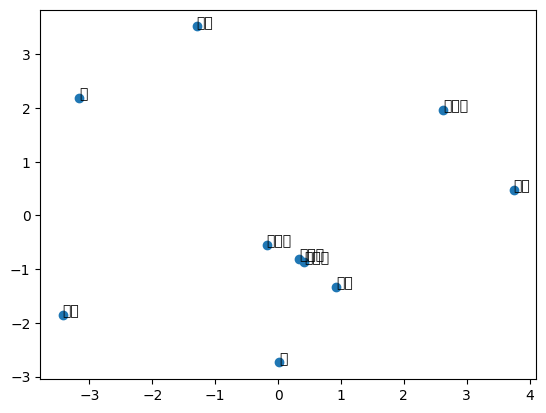

In [36]:
# 시각화
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(word_to_id):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [37]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


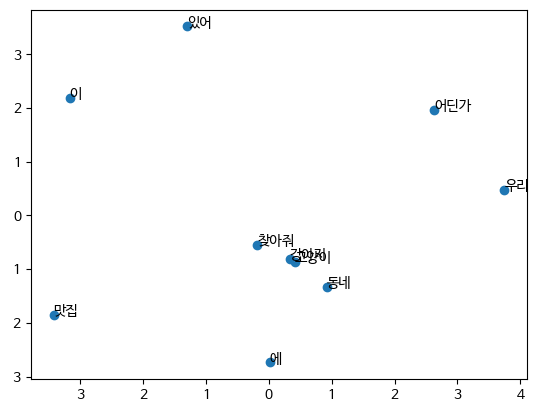

In [38]:
# 시각화
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(word_to_id):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

이제 여러분의 데이터로 해보세요!